Traitement et ebtrainement du modèl 

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

#  Chemins
DATASET_PATH = r'C:\Users\smour\Documents\HACKATHON\hackaton2025\archive2\train'
OUTPUT_PATH = r'C:\Users\smour\Documents\HACKATHON\hackaton2025\archive4_preprocessed\train'

IMG_SIZE = 48  # Taille standardisée
TARGET_IMAGES_PER_CLASS = 25000  # Objectif par classe
IS_GRAYSCALE = False  # True si noir & blanc, False si couleur

# ✅ Augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.GaussNoise(p=0.2),
])

#  Vérifier si une image est corrompue
def is_valid_image(file_path):
    try:
        img = cv2.imread(file_path)
        if img is None:
            return False
        return True
    except Exception:
        return False

#  Charger et prétraiter une image
def process_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE if IS_GRAYSCALE else cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    if IS_GRAYSCALE:
        img = np.expand_dims(img, axis=-1)  # Assurer format (48, 48, 1)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Assurer format RGB
    
    img = img.astype(np.float32) / 255.0  # Normalisation
    return img

#  Fonction pour traiter le dataset en reprenant là où il s'est arrêté
def clean_and_balance_dataset(source_path, output_path):
    os.makedirs(output_path, exist_ok=True)

    for class_name in os.listdir(source_path):
        class_path = os.path.join(source_path, class_name)
        output_class_path = os.path.join(output_path, class_name)
        
        if not os.path.isdir(class_path):
            continue  # Ignore fichiers non dossiers

        os.makedirs(output_class_path, exist_ok=True)
        
        # Vérifier le nombre d'images déjà sauvegardées pour cette classe
        existing_files = [f for f in os.listdir(output_class_path) if f.endswith('.png')]
        current_count = len(existing_files)
        print(f"{class_name}: {current_count} images déjà présentes.")
        
        # Si la classe est déjà complète, passer à la suivante
        if current_count >= TARGET_IMAGES_PER_CLASS:
            print(f"Classe {class_name} déjà complète.")
            continue
        
        images = []
        valid_files = [f for f in os.listdir(class_path) if is_valid_image(os.path.join(class_path, f))]
        
        # Charger les images originales (jusqu'à TARGET_IMAGES_PER_CLASS)
        for file in tqdm(valid_files, desc=f"Chargement {class_name}"):
            file_path = os.path.join(class_path, file)
            img = process_image(file_path)
            images.append(img)
            if len(images) >= TARGET_IMAGES_PER_CLASS:
                break
        
        # Si le nombre d'images originales est insuffisant, générer des images supplémentaires
        if len(images) < TARGET_IMAGES_PER_CLASS:
            print(f"Classe {class_name} sous-représentée: génération d'images supplémentaires.")
            while len(images) < TARGET_IMAGES_PER_CLASS:
                augmented_images = []
                for img in images:
                    augmented = augmentations(image=img)["image"]
                    augmented_images.append(augmented)
                    if len(images) + len(augmented_images) >= TARGET_IMAGES_PER_CLASS:
                        break
                images = np.concatenate((images, np.array(augmented_images)), axis=0)
        
        # Sauvegarde des images manquantes
        for idx in range(current_count, TARGET_IMAGES_PER_CLASS):
            img = images[idx]
            img_save = (img * 255).astype(np.uint8)
            output_file = os.path.join(output_class_path, f"{idx}.png")
            cv2.imwrite(output_file, img_save)
        
        print(f" {class_name}: ajout de {TARGET_IMAGES_PER_CLASS - current_count} images.")

# 🚀 Traitement du dataset d'entraînement
clean_and_balance_dataset(DATASET_PATH, OUTPUT_PATH)
print("🎯 Dataset nettoyé et équilibré avec succès !")


c:\Users\smour\Documents\HACKATHON\.venv\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


0: 25000 images déjà présentes.
Classe 0 déjà complète.
1: 25000 images déjà présentes.
Classe 1 déjà complète.
2: 25000 images déjà présentes.
Classe 2 déjà complète.
3: 0 images déjà présentes.


Chargement 3: 100%|██████████| 14090/14090 [00:47<00:00, 294.37it/s]


Classe 3 sous-représentée: génération d'images supplémentaires.
✅ 3: ajout de 25000 images.
4: 0 images déjà présentes.


Chargement 4: 100%|██████████| 6378/6378 [00:15<00:00, 412.63it/s]


Classe 4 sous-représentée: génération d'images supplémentaires.
✅ 4: ajout de 25000 images.
5: 0 images déjà présentes.


Chargement 5: 100%|██████████| 3803/3803 [00:14<00:00, 262.54it/s]


Classe 5 sous-représentée: génération d'images supplémentaires.
✅ 5: ajout de 25000 images.
6: 0 images déjà présentes.


Chargement 6: 100%|██████████| 24882/24882 [06:54<00:00, 60.00it/s]


Classe 6 sous-représentée: génération d'images supplémentaires.
✅ 6: ajout de 25000 images.
🎯 Dataset nettoyé et équilibré avec succès !


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import albumentations as A

#  Chemins
VAL_DATASET_PATH = r'C:\Users\smour\Documents\HACKATHON\hackaton2025\archive2\val'
OUTPUT_VAL_PATH = r'C:\Users\smour\Documents\HACKATHON\hackaton2025\archive4_preprocessed\val'

IMG_SIZE = 48  # Taille standardisée
TARGET_IMAGES_PER_CLASS = 1500  # Objectif par classe
IS_GRAYSCALE = True  # Mettre False si on veut de la couleur

# Augmentations pour compléter les classes sous-représentées
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.GaussNoise(p=0.2),
])

# Vérification des images corrompues
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception:
        return False

# Chargement et prétraitement des images
def process_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE if IS_GRAYSCALE else cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Redimensionner
    if IS_GRAYSCALE:
        img = np.expand_dims(img, axis=-1)  # Format (48, 48, 1)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Assurer format RGB
    img = img.astype(np.float32) / 255.0  # Normalisation entre 0 et 1
    return img

# Fonction pour traiter le dataset de validation en reprenant là où il s'est arrêté
def clean_and_balance_dataset(source_path, output_path):
    os.makedirs(output_path, exist_ok=True)

    for class_name in os.listdir(source_path):
        class_path = os.path.join(source_path, class_name)
        output_class_path = os.path.join(output_path, class_name)
        
        if not os.path.isdir(class_path):
            continue  # Ignore les fichiers non dossiers

        os.makedirs(output_class_path, exist_ok=True)
        
        # Vérifier combien d'images sont déjà présentes
        existing_files = [f for f in os.listdir(output_class_path) if f.endswith('.png')]
        current_count = len(existing_files)
        print(f"{class_name}: {current_count} images déjà présentes.")
        
        if current_count >= TARGET_IMAGES_PER_CLASS:
            print(f"Classe {class_name} déjà complète.")
            continue

        images = []
        valid_files = [f for f in os.listdir(class_path) if is_valid_image(os.path.join(class_path, f))]
        
        #  Étape 1 : Charger les images originales jusqu'à TARGET_IMAGES_PER_CLASS ou moins
        for file in tqdm(valid_files, desc=f"Traitement {class_name}"):
            file_path = os.path.join(class_path, file)
            img = process_image(file_path)
            images.append(img)
            if len(images) >= TARGET_IMAGES_PER_CLASS:
                break
        
        #  Étape 2 : Si la classe est sous-représentée, générer des images supplémentaires
        while len(images) < TARGET_IMAGES_PER_CLASS:
            augmented_images = []
            for img in images:
                augmented = augmentations(image=img)["image"]
                augmented_images.append(augmented)
                if len(images) + len(augmented_images) >= TARGET_IMAGES_PER_CLASS:
                    break
            images = np.concatenate((images, np.array(augmented_images)), axis=0)

        # Sauvegarde uniquement des images manquantes
        for idx in range(current_count, TARGET_IMAGES_PER_CLASS):
            img = images[idx]
            img_save = (img * 255).astype(np.uint8)  # Conversion en entier
            output_file = os.path.join(output_class_path, f"{idx}.png")
            cv2.imwrite(output_file, img_save)

        print(f" {class_name}: sauvegardé {TARGET_IMAGES_PER_CLASS - current_count} images supplémentaires")

#  Traitement du dataset de validation
clean_and_balance_dataset(VAL_DATASET_PATH, OUTPUT_VAL_PATH)
print(" Dataset de validation nettoyé et équilibré avec succès (reprise possible)!")


0: 0 images déjà présentes.


Traitement 0: 100%|██████████| 500/500 [00:01<00:00, 331.32it/s]


✅ 0: sauvegardé 1500 images supplémentaires
1: 0 images déjà présentes.


Traitement 1: 100%|██████████| 500/500 [00:01<00:00, 315.76it/s]


✅ 1: sauvegardé 1500 images supplémentaires
2: 0 images déjà présentes.


Traitement 2: 100%|██████████| 500/500 [00:01<00:00, 480.15it/s]


✅ 2: sauvegardé 1500 images supplémentaires
3: 0 images déjà présentes.


Traitement 3: 100%|██████████| 500/500 [00:01<00:00, 448.24it/s]


✅ 3: sauvegardé 1500 images supplémentaires
4: 0 images déjà présentes.


Traitement 4: 100%|██████████| 500/500 [00:01<00:00, 442.38it/s]


✅ 4: sauvegardé 1500 images supplémentaires
5: 0 images déjà présentes.


Traitement 5: 100%|██████████| 500/500 [00:01<00:00, 386.90it/s]


✅ 5: sauvegardé 1500 images supplémentaires
6: 0 images déjà présentes.


Traitement 6: 100%|██████████| 500/500 [00:01<00:00, 331.73it/s]


✅ 6: sauvegardé 1500 images supplémentaires
🎯 Dataset de validation nettoyé et équilibré avec succès (reprise possible)!


Found 175000 images belonging to 7 classes.
Found 10500 images belonging to 7 classes.


c:\Users\smour\Documents\HACKATHON\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,423 (1.36 MB)

 Trainable params: 356,423 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\smour\Documents\HACKATHON\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.3280 - loss: 1.6465
Epoch 1: val_accuracy improved from -inf to 0.32279, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 1615s 295ms/step - accuracy: 0.3280 - loss: 1.6465 - val_accuracy: 0.3228 - val_loss: 2.6476 - learning_rate: 0.0010
Epoch 2/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 1:44 19ms/step - accuracy: 0.4375 - loss: 1.3603

c:\Users\smour\Documents\HACKATHON\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.32279 to 0.32308, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.4375 - loss: 1.3603 - val_accuracy: 0.3231 - val_loss: 2.6734 - learning_rate: 0.0010
Epoch 3/30
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4881 - loss: 1.3170
Epoch 3: val_accuracy improved from 0.32308 to 0.32631, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 346s 63ms/step - accuracy: 0.4881 - loss: 1.3170 - val_accuracy: 0.3263 - val_loss: 2.8263 - learning_rate: 0.0010
Epoch 4/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 1:40 18ms/step - accuracy: 0.5625 - loss: 1.0355
Epoch 4: val_accuracy improved from 0.32631 to 0.32746, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 5s 977us/step - accuracy: 0.5625 - loss: 1.0355 - val_accuracy: 0.3275 - val_loss: 2.8522 - learning_rate: 0.0010
Epoch 5/30
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5137 - loss: 1.2553
Epoch 5: val_accuracy improved from 0.32746 to 0.33575, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 213s 39ms/step - accuracy: 0.5137 - loss: 1.2553 - val_accuracy: 0.3357 - val_loss: 2.9250 - learning_rate: 0.0010
Epoch 6/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 1:35 17ms/step - accuracy: 0.4375 - loss: 1.4566
Epoch 6: val_accuracy did not improve from 0.33575
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 5s 951us/step - accuracy: 0.4375 - loss: 1.4566 - val_accuracy: 0.3354 - val_loss: 2.8983 - learning_rate: 0.0010
Epoch 7/30
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5281 - loss: 1.2186
Epoch 7: val_accuracy improved from 0.33575 to 0.33880, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 220s 40ms/step - accuracy: 0.5281 - loss: 1.2186 - val_accuracy: 0.3388 - val_loss: 2.8325 - learning_rate: 0.0010
Epoch 8/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 1:49 20ms/step - accuracy: 0.4688 - loss: 1.1982
Epoch 8: val_accuracy did not improve from 0.33880
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 5s 909us/step - accuracy: 0.4688 - loss: 1.1982 - val_accuracy: 0.3349 - val_loss: 2.8982 - learning_rate: 0.0010
Epoch 9/30
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5408 - loss: 1.1900
Epoch 9: val_accuracy did not improve from 0.33880
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 220s 40ms/step - accuracy: 0.5408 - loss: 1.1900 - val_accuracy: 0.3265 - val_loss: 3.4150 - learning_rate: 0.0010
Epoch 10/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 1:16 14ms/step - accuracy: 0.4688 - loss: 1.4312
Epoch 10: val_accuracy did not improve from 0.33880

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 5s 827us/step - accuracy: 0.

5468/5468 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 0.5587 - loss: 1.1440 - val_accuracy: 0.3417 - val_loss: 3.1517 - learning_rate: 5.0000e-04
Epoch 12/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 1:22 15ms/step - accuracy: 0.5625 - loss: 1.1306
Epoch 12: val_accuracy improved from 0.34165 to 0.34232, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 5s 853us/step - accuracy: 0.5625 - loss: 1.1306 - val_accuracy: 0.3423 - val_loss: 3.1211 - learning_rate: 5.0000e-04
Epoch 13/30
5467/5468 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5716 - loss: 1.1109
Epoch 13: val_accuracy did not improve from 0.34232
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 173s 32ms/step - accuracy: 0.5716 - loss: 1.1109 - val_accuracy: 0.3397 - val_loss: 3.2545 - learning_rate: 5.0000e-04
Epoch 14/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 2:24 27ms/step - accuracy: 0.5000 - loss: 1.0347
Epoch 14: val_accuracy did not improve from 0.34232
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.5000 - loss: 1.0347 - val_accuracy: 0.3384 - val_loss: 3.2829 - learning_rate: 5.0000e-04
Epoch 15/30
5467/5468 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5783 - loss: 1.0983
Epoch 15: val_accuracy improved from 0.34232 to 0.34785, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 218s 40ms/step - accuracy: 0.5783 - loss: 1.0983 - val_accuracy: 0.3478 - val_loss: 3.2087 - learning_rate: 5.0000e-04
Epoch 16/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 1:54 21ms/step - accuracy: 0.5938 - loss: 1.0010
Epoch 16: val_accuracy improved from 0.34785 to 0.34804, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.5938 - loss: 1.0010 - val_accuracy: 0.3480 - val_loss: 3.2100 - learning_rate: 5.0000e-04
Epoch 17/30
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5833 - loss: 1.0794
Epoch 17: val_accuracy improved from 0.34804 to 0.36023, saving model to best_emotion_model.h5


5468/5468 ━━━━━━━━━━━━━━━━━━━━ 201s 37ms/step - accuracy: 0.5833 - loss: 1.0794 - val_accuracy: 0.3602 - val_loss: 3.0941 - learning_rate: 5.0000e-04
Epoch 18/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 1:55 21ms/step - accuracy: 0.5625 - loss: 1.1082
Epoch 18: val_accuracy did not improve from 0.36023
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 5s 1000us/step - accuracy: 0.5625 - loss: 1.1082 - val_accuracy: 0.3599 - val_loss: 3.0767 - learning_rate: 5.0000e-04
Epoch 19/30
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5846 - loss: 1.0743
Epoch 19: val_accuracy did not improve from 0.36023
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.5846 - loss: 1.0743 - val_accuracy: 0.3563 - val_loss: 3.5220 - learning_rate: 5.0000e-04
Epoch 20/30
   1/5468 ━━━━━━━━━━━━━━━━━━━━ 1:22 15ms/step - accuracy: 0.6875 - loss: 1.0545
Epoch 20: val_accuracy did not improve from 0.36023

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
5468/5468 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

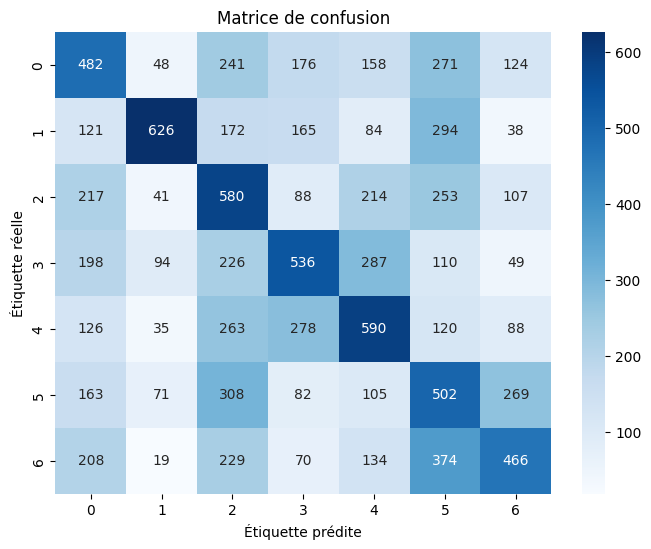

Rapport de classification :
              precision    recall  f1-score   support

           0       0.32      0.32      0.32      1500
           1       0.67      0.42      0.51      1500
           2       0.29      0.39      0.33      1500
           3       0.38      0.36      0.37      1500
           4       0.38      0.39      0.38      1500
           5       0.26      0.33      0.29      1500
           6       0.41      0.31      0.35      1500

    accuracy                           0.36     10500
   macro avg       0.39      0.36      0.37     10500
weighted avg       0.39      0.36      0.37     10500



In [7]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#  Chemins vers les données prétraitées
TRAIN_DIR = r'C:\Users\smour\Documents\HACKATHON\hackaton2025\archive4_preprocessed\train'
VAL_DIR   = r'C:\Users\smour\Documents\HACKATHON\hackaton2025\archive4_preprocessed\val'

# Paramètres
IMG_SIZE = 48
BATCH_SIZE = 32
EPOCHS = 30
# Exemple: si vous avez 7 classes (ex: 0,1,2,3,4,5,6)
NUM_CLASSES = 7

# Création des générateurs d'images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important pour conserver l'ordre des étiquettes
)

# Construction d'un modèle CNN simple
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint("best_emotion_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
]

# Entraînement
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Évaluation finale sur le jeu de validation
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"Précision de validation finale : {val_acc*100:.2f}%")

# --- Calcul et affichage de la matrice de confusion et du rapport de classification ---

# Prédictions sur l'ensemble de validation
# (Utilisez suffisamment d'étapes pour couvrir toutes les images)
Y_pred = model.predict(val_generator, steps=(val_generator.samples // BATCH_SIZE) + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Véritables étiquettes
y_true = val_generator.classes

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage avec seaborn
plt.figure(figsize=(8, 6))
class_names = list(val_generator.class_indices.keys())
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.title("Matrice de confusion")
plt.show()

# Affichage du rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=class_names))

# Sauvegarde finale du modèle (optionnel)
model.save("final_emotion_model.h5")


In [8]:
#sauvegarde du modèle
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# Chemin de sauvegarde
MODEL_PATH = "finalFS_emotion_model.h5"
